## Load the pre-trained CLIP model

In [1]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")


total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in CLIP: {total_params:,}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Total number of parameters in CLIP: 149,620,737


## Load the CIFAR-10 dataset and visualize 5 examples with their class labels from
the train split and test split

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 34128736.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


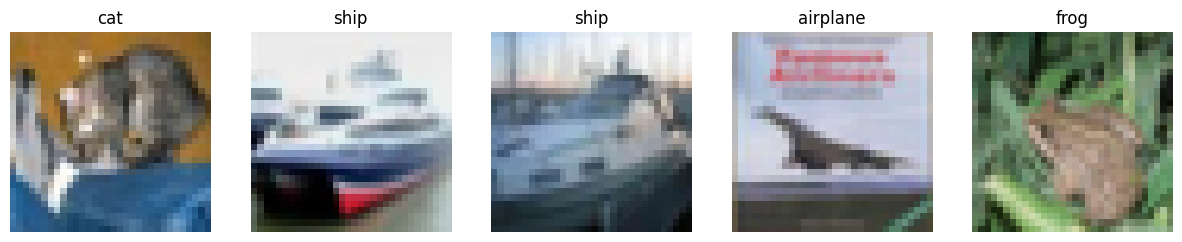

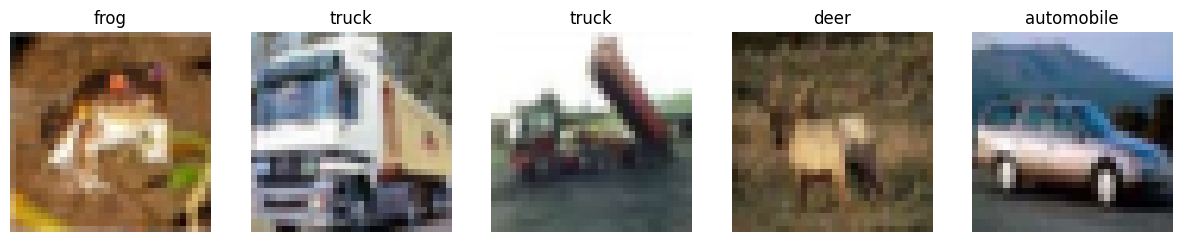

In [3]:
def visualize_images(dataset, num_images=5):
  images = dataset.classes
  fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
  for i in range(5):
      img, label = dataset[i]
      axes[i].imshow(img)
      axes[i].set_title(images[label])
      axes[i].axis('off')
  plt.show()


visualize_images(test_dataset,5)
visualize_images(train_dataset,5)

## Freeze the CLIP model and use its image embeddings for classification

In [4]:
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

processor.feature_extractor.do_rescale = False

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x)
])


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for param in model.parameters():
    param.requires_grad = False


def get_embeddings(dataset, batch_size=256):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Generating embeddings"):
            images = images.to(device)
            inputs = processor(images=images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            embeddings = model.get_image_features(**inputs)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)

    return torch.cat(all_embeddings), torch.cat(all_labels)


train_embeddings, train_labels = get_embeddings(train_dataset)
test_embeddings, test_labels = get_embeddings(test_dataset)


class CLIP_Embedding_Dataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


train_clip_dataset = CLIP_Embedding_Dataset(train_embeddings, train_labels)
test_clip_dataset = CLIP_Embedding_Dataset(test_embeddings, test_labels)

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/processing_clip.py:149: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


Generating embeddings: 100%|██████████| 40/40 [02:36<00:00,  3.92s/it]


In [5]:
class Classifier(torch.nn.Module):
    def __init__(self, input_dim = 512, hidden_dim = 256, output_dim = 10):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


num_epochs = 10

classifier = Classifier().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.01)


train_loader = DataLoader(train_clip_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_clip_dataset, batch_size=256, shuffle=False)


train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0
    correct = 0
    total = 0

    for embeddings, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        embeddings, labels = embeddings.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = classifier(embeddings)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.3f}, Test Acc: {test_accuracy:.3f}")

Epoch 1/10: 100%|██████████| 196/196 [00:01<00:00, 187.03it/s]


Epoch 1/10, Train Loss: 0.198, Train Acc: 0.938, Test Acc: 0.947


Epoch 2/10: 100%|██████████| 196/196 [00:00<00:00, 304.18it/s]


Epoch 2/10, Train Loss: 0.121, Train Acc: 0.960, Test Acc: 0.953


Epoch 3/10: 100%|██████████| 196/196 [00:00<00:00, 217.63it/s]


Epoch 3/10, Train Loss: 0.116, Train Acc: 0.961, Test Acc: 0.954


Epoch 4/10: 100%|██████████| 196/196 [00:00<00:00, 203.72it/s]


Epoch 4/10, Train Loss: 0.107, Train Acc: 0.964, Test Acc: 0.946


Epoch 5/10: 100%|██████████| 196/196 [00:00<00:00, 236.81it/s]


Epoch 5/10, Train Loss: 0.098, Train Acc: 0.967, Test Acc: 0.951


Epoch 6/10: 100%|██████████| 196/196 [00:00<00:00, 199.18it/s]


Epoch 6/10, Train Loss: 0.092, Train Acc: 0.968, Test Acc: 0.951


Epoch 7/10: 100%|██████████| 196/196 [00:00<00:00, 287.06it/s]


Epoch 7/10, Train Loss: 0.085, Train Acc: 0.971, Test Acc: 0.956


Epoch 8/10: 100%|██████████| 196/196 [00:00<00:00, 283.85it/s]


Epoch 8/10, Train Loss: 0.082, Train Acc: 0.972, Test Acc: 0.955


Epoch 9/10: 100%|██████████| 196/196 [00:00<00:00, 282.96it/s]


Epoch 9/10, Train Loss: 0.072, Train Acc: 0.975, Test Acc: 0.952


Epoch 10/10: 100%|██████████| 196/196 [00:00<00:00, 284.09it/s]


Epoch 10/10, Train Loss: 0.072, Train Acc: 0.975, Test Acc: 0.952


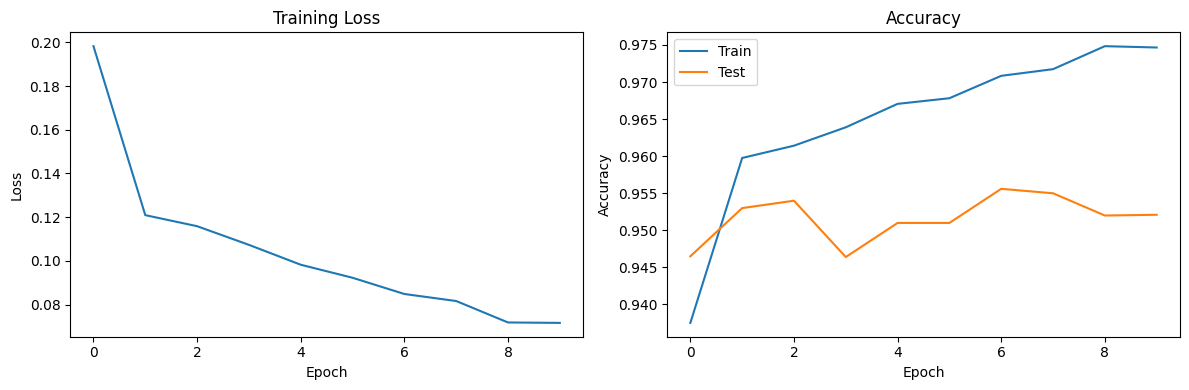

Final Train Accuracy: 0.975
Final Test Accuracy: 0.952


In [6]:
def plot_accuracy(train_losses,train_accuracies, test_accuracies):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses)
  plt.title("Training Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train")
  plt.plot(test_accuracies, label="Test")
  plt.title("Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_accuracy(train_losses,train_accuracies, test_accuracies)

final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]

print(f"Final Train Accuracy: {final_train_accuracy:.3f}")
print(f"Final Test Accuracy: {final_test_accuracy:.3f}")